In [251]:
## Import necessay packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from scipy import linalg as lg
import nltk

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

%matplotlib inline

In [252]:
train = pd.read_csv('./data/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [253]:
test = pd.read_csv(('./data/test.csv'))
test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


# 1. Data Exploration
### *Would drop the 'location' column from the analysis since it has too many missing values

In [254]:
## Check the nunmber of real and fake disaster tweets
len(train[train['target']==1]), len(train[train['target']==0])

(3271, 4342)

/Users/kazutoki.matsui/miniforge3/envs/mytf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

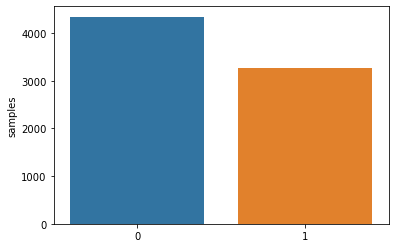

In [255]:
## Check the distribution of target variable

import seaborn as sns
x=train['target'].value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [256]:
# Check missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [257]:
# Check missing values in testing set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

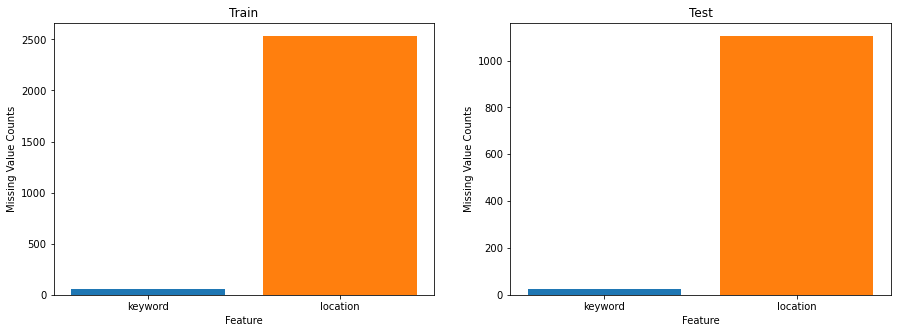

In [258]:
## Visualize Missing Values
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.bar(x='keyword', height= train[['keyword']].isnull().value_counts()[1])
plt.bar(x='location', height = train[['location']].isnull().value_counts()[1])
plt.xlabel('Feature')
plt.ylabel('Missing Value Counts')
plt.title('Train')

plt.subplot(1, 2, 2)
# plt.figure(figsize=(10,5))
plt.bar(x='keyword', height= test[['keyword']].isnull().value_counts()[1])
plt.bar(x='location', height = test[['location']].isnull().value_counts()[1])
plt.xlabel('Feature')
plt.ylabel('Missing Value Counts')
plt.title('Test')

plt.show()

## Check the duplicated tweets

In [259]:
frames = [train[['id', 'keyword', 'location', 'text']],  test]
data = pd.concat(frames)

In [260]:
import collections
duplicates = [item for item, count in collections.Counter(train['text']).items() if count >= 2] ## There are bunch of duplicated tweets...
len(duplicates)

69

In [261]:
targets = []
for d in duplicates:
    index = [ind for ind in train.index[train['text'] == d]]
    targets.append(train['target'][index].values.tolist())
len(targets)

69

In [262]:
df_dup = pd.DataFrame({'text': duplicates, 'targets': targets})
df_dup['targets_set'] = df_dup['targets'].apply(lambda x: set(x))
diff = df_dup[ df_dup['targets_set'].apply(lambda x: len(x)) >=2 ]
diff

,text,targets,targets_set
4,To fight bioterrorism sir.,"[1, 0, 1, 0]","{0, 1}"
7,Mmmmmm I'm burning.... I'm burning buildings I...,"[1, 0]","{0, 1}"
13,I Pledge Allegiance To The P.O.P.E. And The Bu...,"[0, 1]","{0, 1}"
14,like for the music video I want some real acti...,"[1, 0]","{0, 1}"
30,.POTUS #StrategicPatience is a strategy for #G...,"[1, 1, 0, 1]","{0, 1}"
34,He came to a land which was engulfed in tribal...,"[0, 1, 1, 0, 0, 0]","{0, 1}"
40,Who is bringing the tornadoes and floods. Who ...,"[1, 0, 0]","{0, 1}"
41,#foodscare #offers2go #NestleIndia slips into ...,"[1, 1, 0]","{0, 1}"
42,Caution: breathing may be hazardous to your he...,"[1, 0]","{0, 1}"
43,The Prophet (peace be upon him) said 'Save you...,"[0, 0, 1, 0, 0, 1]","{0, 1}"


In [263]:
len(diff)
## It is just 18 obs that have inconsistencies in the labeling. Manually match the targets? 

18

In [264]:
count = -1
for t in diff['text']:
    count += 1
    print(count, t)
    print() # 14, 15 may be disasters?

0 To fight bioterrorism sir.

1 Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...

2 I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????

3 like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit

4 .POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4

5 He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam

6 Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE

7 #foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption

8 Caution: breathing may be hazardous to your health.

9 The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by 

In [265]:
relabels = [ 1 if ind in [14,15] else 0 for ind in np.arange(len(diff))]
diff['relabels']  = relabels
df_dup_rev = df_dup.iloc[diff.index]
df_dup_rev['relabels'] = diff['relabels']
df_dup_rev

/var/folders/sr/8lz8yzn95qn4jm7df6mwv7lw0000gn/T/ipykernel_29946/1965322284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff['relabels']  = relabels
/var/folders/sr/8lz8yzn95qn4jm7df6mwv7lw0000gn/T/ipykernel_29946/1965322284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dup_rev['relabels'] = diff['relabels']


,text,targets,targets_set,relabels
4,To fight bioterrorism sir.,"[1, 0, 1, 0]","{0, 1}",0
7,Mmmmmm I'm burning.... I'm burning buildings I...,"[1, 0]","{0, 1}",0
13,I Pledge Allegiance To The P.O.P.E. And The Bu...,"[0, 1]","{0, 1}",0
14,like for the music video I want some real acti...,"[1, 0]","{0, 1}",0
30,.POTUS #StrategicPatience is a strategy for #G...,"[1, 1, 0, 1]","{0, 1}",0
34,He came to a land which was engulfed in tribal...,"[0, 1, 1, 0, 0, 0]","{0, 1}",0
40,Who is bringing the tornadoes and floods. Who ...,"[1, 0, 0]","{0, 1}",0
41,#foodscare #offers2go #NestleIndia slips into ...,"[1, 1, 0]","{0, 1}",0
42,Caution: breathing may be hazardous to your he...,"[1, 0]","{0, 1}",0
43,The Prophet (peace be upon him) said 'Save you...,"[0, 0, 1, 0, 0, 1]","{0, 1}",0


In [266]:
for text, target in zip(df_dup_rev['text'], df_dup_rev['relabels']):
    index = [ind for ind in train.index[train['text'] == text]]
    train['target'][index] =  target  

train[train['text'] == 'To fight bioterrorism sir.'] ## Replaced inconsistent target values with the consistent labels

/var/folders/sr/8lz8yzn95qn4jm7df6mwv7lw0000gn/T/ipykernel_29946/3795622803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'][index] =  target
/var/folders/sr/8lz8yzn95qn4jm7df6mwv7lw0000gn/T/ipykernel_29946/3795622803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'][index] =  target
/var/folders/sr/8lz8yzn95qn4jm7df6mwv7lw0000gn/T/ipykernel_29946/3795622803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

,id,keyword,location,text,target
610,881,bioterrorism,NaN,To fight bioterrorism sir.,0
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
630,907,bioterrorism,NaN,To fight bioterrorism sir.,0
634,916,bioterrorism,NaN,To fight bioterrorism sir.,0


In [267]:
train = train.drop_duplicates(subset=['text'], keep='first') ## Keep the first obs among the duplicates
len(train) ## Dropped around 110 observation that are duplicates

7503

## Create a WordCloud to see what kinds of Keywords are associated with a disaster

In [56]:
data_key = data.dropna(subset=['keyword']).reset_index()
len(data_key['keyword'])

10789

In [12]:
train_key = train.dropna(subset=['keyword']).reset_index()

disaster = train_key[train_key['target']==1]
non_disaster = train_key[train_key['target']==0]

In [17]:
from wordcloud import WordCloud
keywords_one = ' '.join(disaster['keyword'].tolist())
wordcloud = WordCloud(colormap = 'prism', background_color='black',relative_scaling=1)
wordcloudImage = wordcloud.generate(keywords_one )

wordcloudFile = wordcloudImage.to_file('keywords.png')

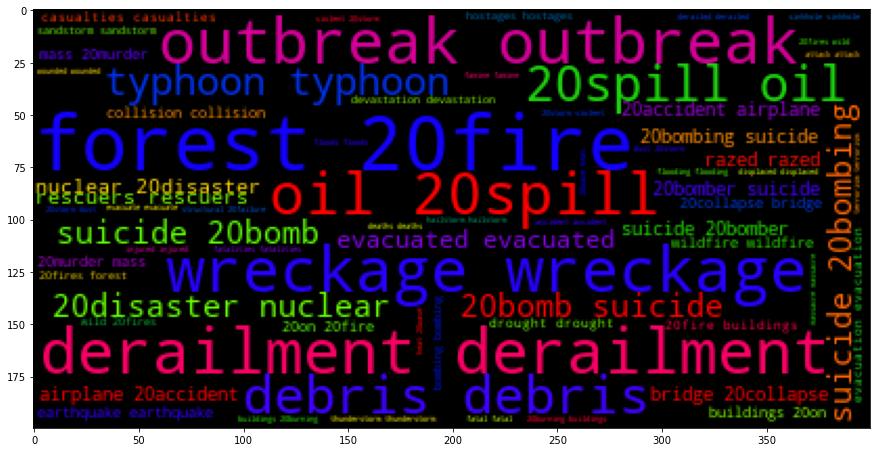

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

im = Image.open('keywords.png')
fig,aux = plt.subplots(figsize=(15,15))
aux.imshow(im)

### Latent Semantic Analysis/Bag-Of-Words/ Tf-IDf
GPT3 may be the best model?

# 2. Text Preprocessing

In [ ]:
import re
import string
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

In [286]:
# def text_cleaner(texts):
#     '''
#     Input: list of texts, e.g. train['text']
#     Output: list of cleaned texts tokenized, e.g. [['our', 'deeds', 'are', 'the',...],..]
#     '''
#     ## Remove URLs as this may be irrelevan to judge the target
#     txt_no_url  = [re.sub(r'http\S+', '', te) for te in texts]

#     ## Remove punctuations
#     txt_nopunct = ["".join([c for c in te if c not in string.punctuation]) for te in txt_no_url]

#     ## Tokenize the tweets by TweetTokenizer
#     txt_tokenized  = [re.split('\W+', txt.lower()) for txt in txt_nopunct]

#     ## Remove stop words
#     txt_clean = [word for word in txt_tokenized if word not in stopwords]
    
#     return txt_clean

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kazutoki.matsui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [295]:
def text_cleaner(text):
    '''
    Input: list of texts, e.g. train['text']
    Output: list of cleaned texts tokenized, e.g. [['our', 'deeds', 'are', 'the',...],..]
    '''
    ## Remove URLs as this may be irrelevan to judge the target
    txt_no_url  = re.sub(r'http\S+', '', text)

    ## Remove punctuations
    txt_nopunct = "".join([w for w in txt_no_url if w not in string.punctuation])
    
    ## Tokenize the tweets by TweetTokenizer
    txt_tokenized  = re.split('\W+', txt_nopunct.lower())

    ## Remove stop words
    txt_clean = [word for word in txt_tokenized if word not in stopwords]
    
    return txt_clean

train['cleaned_text'] = train['text'].apply(lambda x: text_cleaner(x)) ## Cleaned texts in training set
train['cleaned_text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7604    [worldnews, fallen, powerlines, glink, tram, u...
7605    [flip, side, im, walmart, bomb, everyone, evac...
7606    [suicide, bomber, kills, 15, saudi, security, ...
7608    [two, giant, cranes, holding, bridge, collapse...
7612    [latest, homes, razed, northern, california, w...
Name: cleaned_text, Length: 7503, dtype: object

In [296]:
## Do the same preprocessing to the testing set
test['cleaned_text'] = test['text'].apply(lambda x: text_cleaner(x)) ## Cleaned texts in training set
test['cleaned_text']

0                        [happened, terrible, car, crash]
1       [heard, earthquake, different, cities, stay, s...
2       [forest, fire, spot, pond, geese, fleeing, acr...
3              [apocalypse, lighting, spokane, wildfires]
4           [typhoon, soudelor, kills, 28, china, taiwan]
                              ...                        
3258    [earthquake, safety, los, angeles, ûò, safety,...
3259    [storm, ri, worse, last, hurricane, cityamp3ot...
3260                 [green, line, derailment, chicago, ]
3261    [meg, issues, hazardous, weather, outlook, hwo, ]
3262    [cityofcalgary, activated, municipal, emergenc...
Name: cleaned_text, Length: 3263, dtype: object

In [ ]:
corpus = np.array(train['text']).tolist()
corpus[:10]

In [13]:
import string
## remove punctuations
def remove_punct(txt):
  txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
  return txt_nopunct

train['text_punkt'] = [remove_punct(c) for c in corpus]
train['text_punkt'][:10]

In [ ]:
from nltk.tokenize import TweetTokenizer 

tknzr = TweetTokenizer()
# train['text_tokenized'] = [tknzr.tokenize(t) for t in train['text']]

train['text_tokenized'] = train['text_punkt'].apply(lambda x: tknzr.tokenize(x.lower()))
train['text_tokenized']

# import re
# ## Tokenize the tweets
# def tokenize(txt):
#   tokens = re.split('\W+', txt)
#   return tokens

# train['text_tokenized'] = train['text'].apply(lambda x: tokenize(x.lower()))
# train['text_tokenized']

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(txt_tokenized):
  txt_clean = [word for word in txt_tokenized if word not in stopwords]
  return txt_clean

train['text_tokenized'] = train['text_tokenized'].apply(lambda x: remove_stopwords(x))
train['text_tokenized'][:10]

In [ ]:
from nltk.stem import PorterStemmer
## Stemming the tweets
ps = PorterStemmer()

def stemming(tokenized_text):
  text = [ps.stem(word) for word in tokenized_text]
  return tokenized_text

train['text_cleaned'] = train['text_tokenized'].apply(lambda x: stemming(x))
train['text_cleaned']

In [ ]:
np.array(train['text_cleaned']).tolist()[0]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
np.set_printoptions(precision=4, suppress=True)

vect = CountVectorizer()
bag_of_words = vect.fit_transform()

df = pd.DataFrame(bag_of_words.toarray(), columns= vect.get_feature_names())
df

In [ ]:
transformer = TfidfTransformer() 
tfidf = transformer.fit_transform(X) 
pd.DataFrame(tfidf.toarray()).T

### TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

## Bert Modelling

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
%%time

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

## Submission Preparation

In [ ]:
# sample_submission = pd.read_csv("./data/sample_submission.csv")
# # sample_submission["target"] = clf.predict(test_vectors)
# sample_submission.to_csv("submission.csv", index=False)